<a href="https://colab.research.google.com/github/fengyao135/llms-deep-dive-tutorials/blob/main/tutorials/chapter3/tutorial1/prompt_vs_pretrain_finetune_methods_in_text_classification_and_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3 Tutorial #1: Prompt vs. Pre-Train/Fine-Tune Methods in Text Classification and NER

This tutorial will show how prompt-based learning can achieve superior results compared to head-based fine-tuning in data-sparse training situations. While prompting may not consistently outperform fine-tuning with more significant amounts of data and longer training cycles, prompt learning has a significant advantage in its efficiency. It allows LLMs to be adapted to new tasks more quickly and at a lower cost. It is far less dependent on data volume and quality, and fewer data means less expensive computation.

Our experiment will directly compare the zero-shot and few-shot capabilities of the pre-train/fine-tune and prompt-based learning approaches in their application to text classification and named-entity recognition. We adopt BERT as the basis for our fine-tuning exercises for this test. Using PyTorch, supplemented with OpenPrompt for the prompt-based portion, we will iteratively refine our BERT models with larger and larger subsets of the training data, predicting on the validation sets at regular intervals to show how the model is responding to few-shot learning. Finally, we will compare learning curves for the two tuning approaches for each NLP task and discuss the implications.

## Installation and Imports

In [1]:
!pip install transformers==4.19.0
!pip install datasets
!pip install openprompt
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 43.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.19.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import copy
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset, Dataset, concatenate_datasets

from transformers import (
    Trainer,
    TrainingArguments,
    BertForTokenClassification,
    BertForSequenceClassification,
    DataCollatorWithPadding,
    AutoTokenizer,
    AdamW
)

from openprompt.data_utils import InputExample
from openprompt.plms import load_plm
from openprompt.prompts import ManualTemplate, ManualVerbalizer
from openprompt import PromptDataLoader, PromptForClassification

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

use_cuda = torch.cuda.is_available()

## Text Classification

### Load and format data

In [4]:
dataset = load_dataset("glue", "sst2")
seed = 0

## Keep only 1000 of the training data to speed up preprocessing/tokenization
dataset["train"] = dataset["train"].shuffle(seed=seed).select(range(1000))
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [5]:
## Separate the positives and negatives in training to ensure balanced samples.
## This could matter a lot in few-shot
dataset["pos_train"] = dataset["train"].filter(lambda x: x["label"] == 1)
dataset["neg_train"] = dataset["train"].filter(lambda x: x["label"] == 0)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
# we will try different samples evenly split between classes
shot_increments = 5
sample_sizes = [2**i for i in range(4, 4 + shot_increments)]
sample_sizes

[16, 32, 64, 128, 256]

### Head-based fine-tuning

In [7]:
## Instantiate a BERT tokenizer and tokenizer the dataset
def tokenize_function(example):
    return tokenizer(example["sentence"], truncation=True)


tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# rename columns and convert tokenized dataset to pytorch format
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/560 [00:00<?, ? examples/s]

Map:   0%|          | 0/440 [00:00<?, ? examples/s]

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [8]:
## Define the accuracy metric
def compute_acc(eval_preds):
    preds = np.argmax(eval_preds.predictions, axis=-1)
    labels = eval_preds.label_ids
    acc = sum([int(i == j) for i, j in zip(preds, labels)]) / len(labels)
    return acc

In [9]:
## "Zero-shot" i.e. the head has random weights and no training is done
training_args = TrainingArguments("trainer")
finetune_model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", num_labels=2
)
if use_cuda:
    finetune_model = finetune_model.cuda()

trainer = Trainer(
    finetune_model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    tokenizer=tokenizer,
)

## Skip training of the Trainer object for zero-shot
preds = trainer.predict(tokenized_datasets["validation"])
acc = compute_acc(preds)
finetune_scores = [acc]
print(finetune_scores)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:392: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

[0.5091743119266054]


In [10]:
## Now generate a learning curve. loop over different values of k (total samples)
## and calculate accuracy for each
for k in sample_sizes:
    train_sample = concatenate_datasets(
        [
            tokenized_datasets["pos_train"].select(range(k)),
            tokenized_datasets["neg_train"].select(range(k)),
        ]
    )
    training_args = TrainingArguments("trainer")
    model = copy.deepcopy(finetune_model)
    if use_cuda:
        model = model.cuda()

        trainer = Trainer(
            model,
            training_args,
            train_dataset=train_sample,
            # data_collator=data_collator,
            tokenizer=tokenizer,
        )

    trainer.train()
    preds = trainer.predict(tokenized_datasets["validation"])
    acc = compute_acc(preds)
    finetune_scores.append(acc)
    print(finetune_scores)
    torch.cuda.empty_cache()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 32
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Using wandb-core as the SDK backend.  Please r

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 872
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.5091743119266054, 0.49655963302752293]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 872
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 128
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.5091743119266054, 0.49655963302752293, 0.569954128440367]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 872
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 256
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 96
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.5091743119266054, 0.49655963302752293, 0.569954128440367, 0.7568807339449541]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 872
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 512
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 192
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.5091743119266054, 0.49655963302752293, 0.569954128440367, 0.7568807339449541, 0.8486238532110092]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 872
  Batch size = 8


[0.5091743119266054, 0.49655963302752293, 0.569954128440367, 0.7568807339449541, 0.8486238532110092, 0.8658256880733946]


### Prompt-based fine-tuning

In [11]:
## Create a dataset of openprompt InputExamples from the training data
prompt_dataset = {}
for split in ["pos_train", "neg_train", "validation", "test"]:
    prompt_dataset[split] = []
    for data in dataset[split]:
        input_example = InputExample(
            text_a=data["sentence"], label=int(data["label"]), guid=data["idx"]
        )
        prompt_dataset[split].append(input_example)
print(prompt_dataset["pos_train"][0])
print(prompt_dataset["neg_train"][0])

{
  "guid": 24073,
  "label": 1,
  "meta": {},
  "text_a": "a wonderful , ghastly film ",
  "text_b": "",
  "tgt_text": null
}

{
  "guid": 39409,
  "label": 0,
  "meta": {},
  "text_a": "empty stud knockabout ",
  "text_b": "",
  "tgt_text": null
}



In [13]:
## Load the BERT model
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-cased")

## Create the prompt template
template_text = '{"placeholder": "text_a"} it is {"mask"} .'
template = ManualTemplate(tokenizer=tokenizer, text=template_text)

## Create a wrapped tokenizer
wrapped_tokenizer = WrapperClass(
    max_seq_length=128,
    decoder_max_length=3,
    tokenizer=tokenizer,
    truncate_method="head",
)

## Define your verbalizer with desired vocabulatary mapping to pos and neg
verbalizer = ManualVerbalizer(
    tokenizer, num_classes=2, label_words=[["terrible"], ["great"]]
)

## Generate a testing dataloader
val_dataloader = PromptDataLoader(
    prompt_dataset["validation"],
    template,
    tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass,
    batch_size=4,
)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /

In [14]:
## Define the accuracy metric
def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if use_cuda:
                inputs = inputs.cuda()
            logits = model(inputs)
            labels = inputs["label"]
            alllabels.extend(labels.cpu().tolist())
            allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
    acc = sum([int(i == j) for i, j in zip(allpreds, alllabels)]) / len(allpreds)
    return acc

In [15]:
## ** Zero-shot testing **
## Run the evalation set against the prompt model before any finetuning.
## This is equivalent to normal prompt-based inference, relying just on
## the weights tuned into the model and not on any modification.
prompt_model = PromptForClassification(
    plm=copy.deepcopy(plm), template=template, verbalizer=verbalizer
)
prompt_model = prompt_model.cuda()
prompt_scores = [evaluate(prompt_model, val_dataloader)]
prompt_scores

[0.680045871559633]

In [16]:
## Now generate a learning curve. loop over different values of k (total samples)
## and calculate accuracy for each
for k in sample_sizes:
    # they are already shuffled, we can simply select the first k examples each time
    train_sample = prompt_dataset["pos_train"][:k] + prompt_dataset["neg_train"][:k]
    train_dataloader = PromptDataLoader(
        train_sample,
        template,
        tokenizer=tokenizer,
        tokenizer_wrapper_class=WrapperClass,
        shuffle=True,
        batch_size=4,
        seed=seed,
    )

    prompt_model = PromptForClassification(
        plm=copy.deepcopy(plm),
        template=template,
        verbalizer=verbalizer,
        freeze_plm=False,
    )
    prompt_model = prompt_model.cuda()

    loss_func = torch.nn.CrossEntropyLoss()
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in prompt_model.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01,
        },
        {
            "params": [
                p
                for n, p in prompt_model.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    for epoch in range(5):
        tot_loss = 0
        for step, inputs in enumerate(train_dataloader):
            if use_cuda:
                inputs = inputs.cuda()
            logits = prompt_model(inputs)
            labels = inputs["label"]
            loss = loss_func(logits, labels)
            loss.backward()
            tot_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()

    accuracy = evaluate(prompt_model, val_dataloader)
    prompt_scores.append(accuracy)
    print(prompt_scores)
    torch.cuda.empty_cache()

tokenizing: 32it [00:00, 347.72it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.7809633027522935]


tokenizing: 64it [00:00, 609.30it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.7809633027522935, 0.8279816513761468]


tokenizing: 128it [00:00, 1147.69it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.7809633027522935, 0.8279816513761468, 0.8543577981651376]


tokenizing: 256it [00:00, 717.80it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.7809633027522935, 0.8279816513761468, 0.8543577981651376, 0.8600917431192661]


tokenizing: 512it [00:00, 1107.81it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.7809633027522935, 0.8279816513761468, 0.8543577981651376, 0.8600917431192661, 0.8669724770642202]


### Plot the results

In [ ]:
## Scores for the plot in the paper

# finetune_scores = [0.5091743119266054,
#                    0.5068807339449541,
#                    0.6548165137614679,
#                    0.8486238532110092,
#                    0.8623853211009175,
#                    0.8738532110091743]

# prompt_scores = [0.680045871559633,
#                  0.6743119266055045,
#                  0.786697247706422,
#                  0.8474770642201835,
#                  0.8520642201834863,
#                  0.8658256880733946]

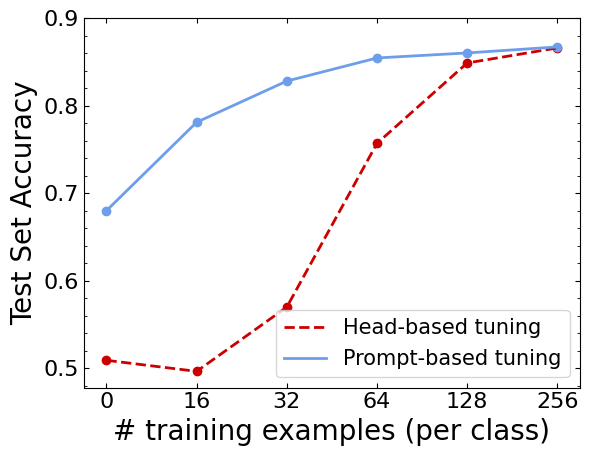

In [17]:
# plot the prompt-based training and pre-train/finetuning learning curves
# against each other

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)

x = [0] + sample_sizes
ax11.plot(
    range(len(x)),
    finetune_scores,
    color="#cc0000",
    lw=2,
    ls="--",
    label="Head-based tuning",
)
ax11.scatter(range(len(x)), finetune_scores, color="#cc0000")
ax11.plot(
    range(len(x)), prompt_scores, color="#6d9eeb", lw=2, label="Prompt-based tuning"
)
ax11.scatter(range(len(x)), prompt_scores, color="#6d9eeb")
ax11.set_xticks(range(len(x)))
ax11.set_xticklabels(x, fontsize=16)
ax11.set_xlabel("# training examples (per class)", fontsize=20)

ax11.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
ax11.set_yticklabels(["0.5", "0.6", "0.7", "0.8", "0.9"], fontsize=16)
ax11.set_ylabel("Test Set Accuracy", fontsize=20)

ax11.xaxis.set_ticks_position("both")
ax11.tick_params(axis="x", which="major", direction="in")
ax11.tick_params(axis="x", which="minor", direction="in")
ax11.yaxis.set_ticks_position("both")
ax11.tick_params(axis="y", which="major", direction="in")
ax11.tick_params(axis="y", which="minor", direction="in")

plt.gca().yaxis.set_minor_locator(MultipleLocator(0.02))

ax11.legend(fontsize=15)

## Named-entity Recognition

### Head-based fine-tuning

#### Load and format data

In [18]:
## Load CoNLL-2003 dataset from huggingface
dataset = load_dataset("conll2003")

## Create dictionary key for CoNLL-2003 NER-tags:
id_to_label = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-MISC": 7,
    "I-MISC": 8,
}
label_to_id = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-LOC",
    6: "I-LOC",
    7: "B-MISC",
    8: "I-MISC",
}

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [19]:
## Prepare the data using three steps.
##   1) downsample train, test, val as desired.
##   2) convert labels from dataset tokenization to BERT tokenization
##   3) tokenize and pad the sentences.

seed = 13

TRN_SAMP = 1024
VAL_SAMP = 500

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
SET_EXTRA_TOK_TO_MINUS_100 = False

pad_length = 128

#######


## Tokenize sentences and return vectors necessary for the training loop
def tokenize_function(tokens):
    return tokenizer.encode_plus(
        tokens,
        is_split_into_words=True,
        pad_to_max_length=True,
        max_length=pad_length,
        return_attention_mask=True,
        return_token_type_ids=True,
    )


def pad_label_example(tokenized_input, labels, label_all_tokens=True):
    ## Look for tokens identified as "None" type -- set label to -100. Else,
    ## use the label from the input label vector.
    word_ids = tokenized_input.word_ids()
    label_ids = []
    for i, word_idx in enumerate(word_ids):
        if word_idx is None:
            label_ids.append(-100)
        else:
            label_ids.append(labels[i - 1])
    return label_ids


## Determine for each word if BERT tokenization differs.
def apply_bert_tok(og_tok_sent, og_lab):
    newlab = []
    ## Determine the tokenization for each word.
    for i, t in enumerate(og_tok_sent):
        ttok = tokenizer(" " + t + " ", add_special_tokens=False)["input_ids"]
        ## If the word splits to subwork tokens, extra spots in the labels.
        for j in range(len(ttok)):
            ## Can either set to -100 or set to same label as the original token.
            if SET_EXTRA_TOK_TO_MINUS_100:
                if j == 0:
                    newlab.append(og_lab[i])
                else:
                    newlab.append(-100)
            else:
                newlab.append(og_lab[i])
    return newlab


## Convert labels to BERT tokenization.
## Note the data comes pretokenized, but the split doesn't match BERT procedure.
## So we tokenize every individual word to determine where word splitting occurs,
## and create a new label vector to account for this.
def bert_token_maker(dataset):
    full_sents, tok_sents, pad_labs = [], [], []
    input_ids, tkntype_ids, attn_masks = [], [], []
    ## Update labels to reflect BERT tokenization
    sents, labs = dataset["sentence"], dataset["labels"]
    new_labs = [apply_bert_tok(sents[i], labs[i]) for i in range(len(labs))]
    ## Create encoded dictionaries for each sentence.
    tok_dicts = [tokenize_function(s) for s in sents]

    for td, l in zip(tok_dicts, new_labs):
        ## Collect the original and tokenized sentence.
        full_sents.append(tokenizer.decode(td["input_ids"], skip_special_tokens=True))
        tok_sents.append(
            [tokenizer.decode(td["input_ids"][i]) for i in range(len(td["input_ids"]))]
        )
        ## Pad labels to align with tokenized sentences.
        pad_labs.append(pad_label_example(td, l))
        ## Collect other training requirements.
        input_ids.append(td["input_ids"])
        tkntype_ids.append(td["token_type_ids"])
        attn_masks.append(td["attention_mask"])

    dataset = Dataset.from_dict(
        {
            "id": dataset["id"],
            "sentence": full_sents,
            "tokens": tok_sents,
            "labels": pad_labs,
            "input_ids": input_ids,
            "token_type_ids": tkntype_ids,
            "attention_mask": attn_masks,
        }
    )

    return dataset


def data_prep(dataset):

    ## Remove unneeded columns
    dataset = dataset.remove_columns(["pos_tags", "chunk_tags"])
    dataset = dataset.rename_column("tokens", "sentence")
    dataset = dataset.rename_column("ner_tags", "labels")

    ## Downsample to a (pseudo)random subset.
    dataset["train"] = dataset["train"].shuffle(seed=seed).select(range(TRN_SAMP))
    dataset["validation"] = (
        dataset["validation"].shuffle(seed=seed).select(range(VAL_SAMP))
    )

    ## Tokenize sentences and align labels.
    dataset["train"] = bert_token_maker(dataset["train"])
    dataset["validation"] = bert_token_maker(dataset["validation"])

    return dataset


tokenized_datasets = data_prep(dataset)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve/main/voc

In [20]:
## We will try different numbers of samples for the learning curve
shot_increments = 7
sample_sizes = [
    0,
] + [2**i for i in range(3, 4 + shot_increments)]
sample_sizes

[0, 8, 16, 32, 64, 128, 256, 512, 1024]

#### Fine-tune the model

In [ ]:
## Define F1-score metric
def compute_ptft_f1(preds, labs):
    preds_clean = preds.argmax(axis=2)[labs != -100]
    labs_clean = labs[labs != -100]
    # precision
    pmask = np.isin(preds_clean, [1, 3, 5, 7])
    p = preds_clean[pmask] == labs_clean[pmask]
    p = p.astype(float).sum() / sum(pmask)
    # recall
    rmask = np.isin(labs_clean, [1, 3, 5, 7])
    r = preds_clean[rmask] == labs_clean[rmask]
    r = r.astype(float).sum() / sum(rmask)
    # f1
    return 2.0 * p * r / (p + r)

In [22]:
## Set parameters for training loop, and load BERT model
tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments("trainer")
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased", num_labels=len(label_to_id)
)

## Loop over different samples of k
finetune_scores = []
for i, k in enumerate(sample_sizes):
    if k == 0:
        samps = range(0)  ## zero-shot
    else:
        samps = range(sample_sizes[i - 1], k)  ## iterative training
    train_sample = tokenized_datasets["train"].select(samps)
    training_args = TrainingArguments("trainer")
    if use_cuda:
        model = model.cuda()

    trainer = Trainer(
        model,
        training_args,
        train_dataset=train_sample,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    ## If k==0, do zero-shot testing. Otherwise, activate training.
    if k > 0:
        trainer.train()
    preds = trainer.predict(tokenized_datasets["validation"])
    f1 = compute_ptft_f1(preds.predictions, preds.label_ids)
    finetune_scores.append(f1)
    print(finetune_scores)
    torch.cuda.empty_cache()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Tota

[0.0253592561284869]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.0253592561284869, 0.018509498295177788]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


<ipython-input-21-8cb556e7746e>:9: RuntimeWarning: invalid value encountered in scalar divide
  p = p.astype(float).sum()/sum(pmask)
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6
Automatic Weights & Biases logging enabled, t

[0.0253592561284869, 0.018509498295177788, nan]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


<ipython-input-21-8cb556e7746e>:15: RuntimeWarning: invalid value encountered in scalar divide
  return 2.*p*r/(p+r)
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 32
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
Automatic Weights & Biases logging enabled, to disable set o

[0.0253592561284869, 0.018509498295177788, nan, nan]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.0253592561284869, 0.018509498295177788, nan, nan, 0.3613687240166294]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 128
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.0253592561284869, 0.018509498295177788, nan, nan, 0.3613687240166294, 0.5799701046337817]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 96
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.0253592561284869, 0.018509498295177788, nan, nan, 0.3613687240166294, 0.5799701046337817, 0.6973451327433627]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 512
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 192
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


[0.0253592561284869, 0.018509498295177788, nan, nan, 0.3613687240166294, 0.5799701046337817, 0.6973451327433627, 0.7811256395679362]


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: id, tokens, sentence. If id, tokens, sentence are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 500
  Batch size = 8


[0.0253592561284869, 0.018509498295177788, nan, nan, 0.3613687240166294, 0.5799701046337817, 0.6973451327433627, 0.7811256395679362, 0.8520231213872833]


### Prompt-based fine-tuning

#### Load and format data

In [23]:
dataset = load_dataset("conll2003")

id_to_label = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-MISC": 7,
    "I-MISC": 8,
}
label_to_id = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-LOC",
    6: "I-LOC",
    7: "B-MISC",
    8: "I-MISC",
}

In [24]:
## Create mapping for entity ids to indexes 0-4.
label_to_label = {
    0: 0,  ## non-entity
    1: 1,  ## person
    3: 2,  ## organization
    5: 3,  ## location
    7: 4,
}  ## misc
TRN_SAMP = 1024
VAL_SAMP = 500
seed = 13


## Identify each entity in each sample, and determine if it is one or multiple
## tokens long. this allows us to generate individual prompts for each entity.
## Save each entity along with its NER tag.
def gen_entity_tags(sample):
    tokens, labels = sample["tokens"], sample["ner_tags"]
    total = len(tokens)
    entities, tags = [], []
    for idx, (t, l) in enumerate(zip(tokens, labels)):
        ## Collect non-entities
        if l == 0:
            entities.append(t)
            tags.append(label_to_label[l])
            continue

        ## Collect entites
        if l in (1, 3, 5, 7):
            ## If entity is final token, save
            if idx == total - 1:
                entities.append(t)
                tags.append(label_to_label[l])
                continue

            ## If entity is one token, save.
            if labels[idx + 1] != l + 1:
                entities.append(t)
                tags.append(label_to_label[l])
                continue

            ## If entity continues to the next token, find how long it goes.
            cont = True
            extra = 1
            while cont:
                ## Check if we've reached the end
                if idx + extra == total - 1:
                    cont = False
                elif labels[idx + extra + 1] == l + 1:
                    extra += 1
                else:
                    cont = False
            whole_ent = " ".join(tokens[idx : idx + extra + 1])
            entities.append(whole_ent)
            tags.append(label_to_label[l])

    return entities, tags


## Create a dictionary-based dataset to save each entity, its tag, and its
## source sentence.
def prompt_data_prep(dataset):
    ## Downsample
    dataset["train"] = dataset["train"].shuffle(seed=seed).select(range(TRN_SAMP))
    dataset["validation"] = (
        dataset["validation"].shuffle(seed=seed).select(range(VAL_SAMP))
    )

    ## Loop through data to locate entities and save tags
    pr_data = {}
    for split in ["train", "validation"]:
        pr_data[split] = []
        for i, samp in enumerate(dataset[split]):
            entities, tags = gen_entity_tags(samp)
            sentence = " ".join(entities)

            ## Save entities and tags into openprompt InputExamples
            for entity, tag in zip(entities, tags):
                input_example = InputExample(
                    text_a=sentence,
                    text_b=entity,
                    label=tag,
                    guid=i,
                )
                pr_data[split].append(input_example)

    return pr_data


prompt_dataset = prompt_data_prep(dataset)

#### Prompt-tune the model

In [25]:
# load the BERT prompt model
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-cased")
wrapped_tokenizer = WrapperClass(
    max_seq_length=128,
    decoder_max_length=3,
    tokenizer=tokenizer,
    truncate_method="head",
)

# create a cloze template for training and testing
template_text = (
    '{"placeholder": "text_a"}. {"placeholder": "text_b"} is a {"mask"} entity.'
)
template = ManualTemplate(tokenizer=tokenizer, text=template_text)

# define verbalizer corresponding to different named entity classes
verbalizer = ManualVerbalizer(
    tokenizer,
    num_classes=5,
    label_words=[
        ["non-"],
        ["person"],
        ["organization"],
        ["location"],
        ["other"],
    ],
)

# create a validation dataloader
val_dataloader = PromptDataLoader(
    prompt_dataset["validation"],
    template,
    tokenizer=tokenizer,
    tokenizer_wrapper_class=WrapperClass,
    batch_size=32,
)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /

In [26]:
# define F1-score metric
def compute_prompt_f1(model, val_dataloader):
    model.eval()
    allpreds, alllabels = [], []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if use_cuda:
                inputs = inputs.cuda()
            logits = model(inputs)
            labels = inputs["label"]
            alllabels.extend(labels.cpu().tolist())
            allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
            if step % 10 == 0:
                print(step, "of", len(val_dataloader), "done")
    labs_clean, preds_clean = np.array(alllabels), np.array(allpreds)
    # precision
    pmask = preds_clean != 0
    p = preds_clean[pmask] == labs_clean[pmask]
    p = p.astype(float).sum() / sum(pmask)
    # recall
    rmask = labs_clean != 0
    r = preds_clean[rmask] == labs_clean[rmask]
    r = r.astype(float).sum() / sum(rmask)
    # f1
    return 2.0 * p * r / (p + r)

In [ ]:
# loop over different values of k and save accuracy for each
prompt_model = PromptForClassification(
    plm=copy.deepcopy(plm), template=template, verbalizer=verbalizer, freeze_plm=False
)
prompt_model = prompt_model.cuda()

prompt_scores = []
sample_sizes = [0, 8, 16, 32, 64, 128, 256, 512, 1024]
for ind, k in enumerate(sample_sizes):
    ## If zero-shot, proceed to predictions. else, go through training loop
    if k != 0:
        ## define dataset and build dataloader
        if ind == 0:
            k0 = 0
        else:
            k0 = sample_sizes[ind - 1]
        train_sample = [samp for samp in prompt_dataset["train"] if k0 <= samp.guid < k]
        train_dataloader = PromptDataLoader(
            train_sample,
            template,
            tokenizer=tokenizer,
            tokenizer_wrapper_class=WrapperClass,
            shuffle=True,
            batch_size=4,
            seed=seed,
        )

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p
                    for n, p in prompt_model.named_parameters()
                    if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.01,
            },
            {
                "params": [
                    p
                    for n, p in prompt_model.named_parameters()
                    if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

        for epoch in range(5):
            tot_loss = 0
            for step, inputs in enumerate(train_dataloader):
                if use_cuda:
                    inputs = inputs.cuda()
                logits = prompt_model(inputs)
                labels = inputs["label"]
                loss = loss_func(logits, labels)
                loss.backward()
                tot_loss += loss.item()
                optimizer.step()
                optimizer.zero_grad()

    prompt_scores.append(compute_prompt_f1(prompt_model, val_dataloader))
    print(prompt_scores)
    torch.cuda.empty_cache()

0 of 236 done
10 of 236 done
20 of 236 done
30 of 236 done
40 of 236 done
50 of 236 done
60 of 236 done
70 of 236 done
80 of 236 done
90 of 236 done
100 of 236 done
110 of 236 done
120 of 236 done


### Plot the results

In [ ]:
# Scores for the plot in the paper

# finetune_scores = [0.06870229007633588,
#                    0.049224544841537425,
#                    0.0022522522522522522,
#                    0.003370786516853933,
#                    0.3323353293413174,
#                    0.5577981651376147,
#                    0.7157034442498541,
#                    0.7894438138479001,
#                    0.8526011560693642]

# prompt_scores = [0.07118375955707884,
#                  0.5788359788359789,
#                  0.6481854838709677,
#                  0.727367870225013,
#                  0.7866666666666666,
#                  0.8365437534397359,
#                  0.8671706263498921,
#                  0.8303769401330378,
#                  0.855135135135135]

In [ ]:
fig1 = plt.figure()
ax11 = fig1.add_subplot(111)

x = sample_sizes
ax11.plot(
    range(len(x)),
    finetune_scores,
    color="#cc0000",
    lw=2,
    ls="--",
    label="Head-based tuning",
)
ax11.scatter(range(len(x)), finetune_scores, color="#cc0000")
ax11.plot(
    range(len(x)), prompt_scores, color="#6d9eeb", lw=2, label="Prompt-based tuning"
)
ax11.scatter(range(len(x)), prompt_scores, color="#6d9eeb")

ax11.set_xticks(range(len(x)))
ax11.set_xticklabels(x, fontsize=16)
ax11.set_xlabel("# training examples (per class)", fontsize=20)

ax11.set_ylim(-0.04, 1.08)
ax11.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax11.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=16)
ax11.set_ylabel("Test Set F1-score", fontsize=20)

ax11.xaxis.set_ticks_position("both")
ax11.tick_params(axis="x", which="major", direction="in")
ax11.tick_params(axis="x", which="minor", direction="in")
ax11.yaxis.set_ticks_position("both")
ax11.tick_params(axis="y", which="major", direction="in")
ax11.tick_params(axis="y", which="minor", direction="in")

plt.gca().yaxis.set_minor_locator(MultipleLocator(0.04))

ax11.legend(fontsize=15)